In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import tensorflow as tf
from tensorflow.python.framework import ops

from numpy import array
import os
from PIL import Image
import glob
import PIL

In [40]:
np.random.seed(1)
X_train=np.random.randn(10,100)
Y_train=np.random.randn(1,100)
X_test=np.random.randn(10,20)
Y_test=np.random.randn(1,20)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 100
number of test examples = 20
X_train shape: (10, 100)
Y_train shape: (1, 100)
X_test shape: (10, 20)
Y_test shape: (1, 20)


In [51]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 2322* 4128* 3 = 28755648)
    n_y -- scalar, true values zero for cat and one for a dog

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    Tips:
    -  None  let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    X = tf.placeholder(dtype=tf.float32, shape=(n_x, None), name="X")
    Y = tf.placeholder(dtype=tf.float32, shape=(n_y, None), name="Y")

    return X, Y


In [52]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        

    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    W1 = tf.get_variable("W1", [3, 10], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b1 = tf.get_variable("b1", [3, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [2, 3], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b2 = tf.get_variable("b2", [2, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 2], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b3 = tf.get_variable("b3", [1, 1], initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters



In [53]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> sigmoid

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

                                          # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)     # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                   # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)    # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                   # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)    # Z3 = np.dot(W3,Z2) + b3

    return Z3



In [54]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """
    logits = Z3
    labels = Y
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))


    return cost

In [55]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k* mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k* mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X =  shuffled_X[:,num_complete_minibatches*(m-(mini_batch_size*num_complete_minibatches)) : (num_complete_minibatches+1)*(m-(mini_batch_size*num_complete_minibatches))]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches* (m-(mini_batch_size*num_complete_minibatches)) : (num_complete_minibatches+1)*(m-(mini_batch_size*num_complete_minibatches))]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [56]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x,m)= X_train.shape                         # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                print(minibatch_X.shape)
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

(10, 32)
(10, 32)
(10, 32)
(10, 4)
Cost after epoch 0: 1.196710
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)

(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(1

(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
Cost after epoch 500: 0.874681
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32

(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10

(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
Cost after epoch 1000: 0.625911
(10, 32)
(10, 32)
(10, 32)
(10, 

(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(1

(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(10, 4)
(10, 32)
(10, 32)
(10, 32)
(1

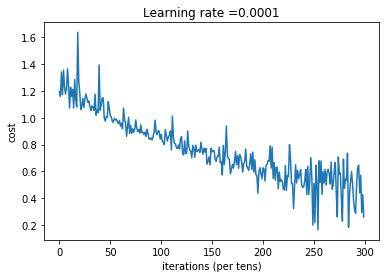

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [57]:
parameters= model(X_train, Y_train, X_test, Y_test)